# Preprocessing Data

In [2]:
import pandas as pd

# Load the dataset
file_path = "holiday_movies.csv"  # Update with the correct path if needed
df = pd.read_csv(file_path)

# Display basic information
df.info()

display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           2265 non-null   object 
 1   title_type       2265 non-null   object 
 2   primary_title    2265 non-null   object 
 3   original_title   2265 non-null   object 
 4   year             2265 non-null   int64  
 5   runtime_minutes  2076 non-null   float64
 6   genres           2233 non-null   object 
 7   simple_title     2265 non-null   object 
 8   average_rating   2265 non-null   float64
 9   num_votes        2265 non-null   int64  
 10  christmas        2265 non-null   bool   
 11  hanukkah         2265 non-null   bool   
 12  kwanzaa          2265 non-null   bool   
 13  holiday          2265 non-null   bool   
dtypes: bool(4), float64(2), int64(2), object(6)
memory usage: 185.9+ KB


,tconst,title_type,primary_title,original_title,year,runtime_minutes,genres,simple_title,average_rating,num_votes,christmas,hanukkah,kwanzaa,holiday
0,tt0020356,movie,Sailor's Holiday,Sailor's Holiday,1929,58.0,Comedy,sailors holiday,5.4,55,False,False,False,True
1,tt0020823,movie,The Devil's Holiday,The Devil's Holiday,1930,80.0,"Drama,Romance",the devils holiday,6.0,242,False,False,False,True
2,tt0020985,movie,Holiday,Holiday,1930,91.0,"Comedy,Drama",holiday,6.3,638,False,False,False,True
3,tt0021268,movie,Holiday of St. Jorgen,Prazdnik svyatogo Yorgena,1930,83.0,Comedy,holiday of st jorgen,7.4,256,False,False,False,True
4,tt0021377,movie,Sin Takes a Holiday,Sin Takes a Holiday,1930,81.0,"Comedy,Romance",sin takes a holiday,6.1,740,False,False,False,True


In [3]:
# Explode genres column for better analysis
df_exploded = df.assign(genres=df['genres'].str.split(',')).explode('genres')

# Define function to group years into periods
def group_years(year, period=5):
    return f"{(year // period) * period}-{((year // period) * period) + (period - 1)}"

df_exploded['year_period'] = df_exploded['year'].apply(lambda x: group_years(x, period=5))

# Interactive Dashboard

In [7]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px


# Initialize Dash app
app = dash.Dash(__name__)

# Layout
app.layout = html.Div([
    html.H1("Holiday Movies Analysis"),

    # Dropdown for selecting period
    dcc.Dropdown(
        id='period-dropdown',
        options=[{'label': str(p), 'value': p} for p in sorted(df_exploded['year_period'].unique())],
        multi=True,
        placeholder="Select periods"
    ),

    # Dropdown for selecting genre
    dcc.Dropdown(
        id='genre-dropdown',
        options=[{'label': g, 'value': g} for g in sorted(df_exploded['genres'].dropna().unique())],
        multi=True,
        placeholder="Select genres"
    ),

    # Scatterplot
    dcc.Graph(id='scatter-plot'),

    # Heatmap
    dcc.Graph(id='heatmap'),

    # Line chart for ratings over time by genre
    dcc.Graph(id='rating-trend'),


    # Line chart for number of votes over time by genre
    dcc.Graph(id='num-votes-trend'),

    # 100% Stacked Area Chart for Number of Movies Over Time by Genre
    dcc.Graph(id='stacked-area-chart'),

])

# Callbacks
@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('period-dropdown', 'value'), Input('genre-dropdown', 'value')]
)
def update_scatter(selected_periods, selected_genres):
    filtered_df = df_exploded
    if selected_periods:
        filtered_df = filtered_df[filtered_df['year_period'].isin(selected_periods)]
    if selected_genres:
        filtered_df = filtered_df[filtered_df['genres'].isin(selected_genres)]
    fig = px.scatter(filtered_df, x='runtime_minutes', y='average_rating', color='genres',
                     title="Runtime vs. Rating by Genre", labels={'runtime_minutes': "Runtime (min)", 'average_rating': "Rating"})
    return fig

@app.callback(
    Output('heatmap', 'figure'),
    [Input('period-dropdown', 'value'), Input('genre-dropdown', 'value')]
)
def update_heatmap(selected_periods, selected_genres):
    filtered_df = df_exploded
    if selected_periods:
        filtered_df = filtered_df[filtered_df['year_period'].isin(selected_periods)]
    if selected_genres:
        filtered_df = filtered_df[filtered_df['genres'].isin(selected_genres)]
    genre_trends = filtered_df.groupby(['year_period', 'genres']).agg({'tconst': 'count'}).reset_index()
    heatmap_data = genre_trends.pivot(index='genres', columns='year_period', values='tconst').fillna(0)
    fig = px.imshow(heatmap_data, labels={'x': "Year Period", 'y': "Genre", 'color': "Movie Count"},
                    title="Holiday Movie Production Trends Over Time", color_continuous_scale='Viridis')
    return fig
@app.callback(
    Output('rating-trend', 'figure'),
    [Input('period-dropdown', 'value'), Input('genre-dropdown', 'value')]
)
def update_rating_trend(selected_periods, selected_genres):
    filtered_df = df_exploded
    if selected_periods:
        filtered_df = filtered_df[filtered_df['year_period'].isin(selected_periods)]
    if selected_genres:
        filtered_df = filtered_df[filtered_df['genres'].isin(selected_genres)]

    rating_trends = filtered_df.groupby(['year_period', 'genres']).agg({'average_rating': 'mean'}).reset_index()

    # Ensure 'year_period' is treated as an ordered categorical variable
    rating_trends['year_period'] = pd.Categorical(rating_trends['year_period'],
                                                  categories=sorted(rating_trends['year_period'].unique()),
                                                  ordered=True)

    fig = px.line(rating_trends, x='year_period', y='average_rating', color='genres',
                  title="Average Rating Over Time by Genre", labels={'average_rating': "Average Rating"})

    return fig

@app.callback(
    Output('stacked-area-chart', 'figure'),
    [Input('period-dropdown', 'value'), Input('genre-dropdown', 'value')]
)
def update_stacked_area(selected_periods, selected_genres):
    filtered_df = df_exploded
    if selected_periods:
        filtered_df = filtered_df[filtered_df['year_period'].isin(selected_periods)]
    if selected_genres:
        filtered_df = filtered_df[filtered_df['genres'].isin(selected_genres)]

    genre_trends = filtered_df.groupby(['year_period', 'genres']).agg({'tconst': 'count'}).reset_index()
    genre_totals = genre_trends.groupby('year_period')['tconst'].transform('sum')
    genre_trends['percentage'] = genre_trends['tconst'] / genre_totals * 100

    fig = px.area(genre_trends, x='year_period', y='percentage', color='genres',
                  title="Percentage of Movies by Genre Over Time (100% Stacked Area Chart)",
                  labels={'percentage': "Percentage of Total Movies"},
                  line_group='genres', groupnorm='percent')
    return fig

@app.callback(
    Output('num-votes-trend', 'figure'),
    [Input('period-dropdown', 'value'), Input('genre-dropdown', 'value')]
)
def update_num_votes_trend(selected_periods, selected_genres):
    filtered_df = df_exploded
    if selected_periods:
        filtered_df = filtered_df[filtered_df['year_period'].isin(selected_periods)]
    if selected_genres:
        filtered_df = filtered_df[filtered_df['genres'].isin(selected_genres)]
    votes_trends = filtered_df.groupby(['year_period', 'genres']).agg({'num_votes': 'sum'}).reset_index()
    fig = px.line(votes_trends, x='year_period', y='num_votes', color='genres',
                  title="Total IMDb Votes Over Time by Genre", labels={'num_votes': "Total Votes"})
    return fig
# Run app
if __name__ == '__main__':
    app.run(debug=True, port=8060)


<IPython.core.display.Javascript object>

# Word Cloud

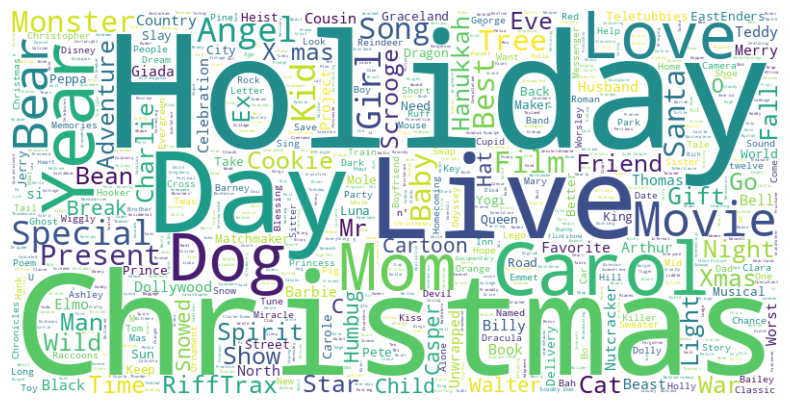

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text from 'primary_title' and 'genres' columns
text_data = " ".join(df_exploded['primary_title'].dropna().astype(str)) + " " + " ".join(df_exploded['genres'].dropna().astype(str))

unique_words = set(text_data.split())

# Generate a word cloud ensuring each word appears only once
wordcloud_unique = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=len(unique_words))
wordcloud_unique.generate(" ".join(unique_words))

# Plot the unique-word word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_unique, interpolation='bilinear')
plt.axis("off")
plt.show()

# Question 2

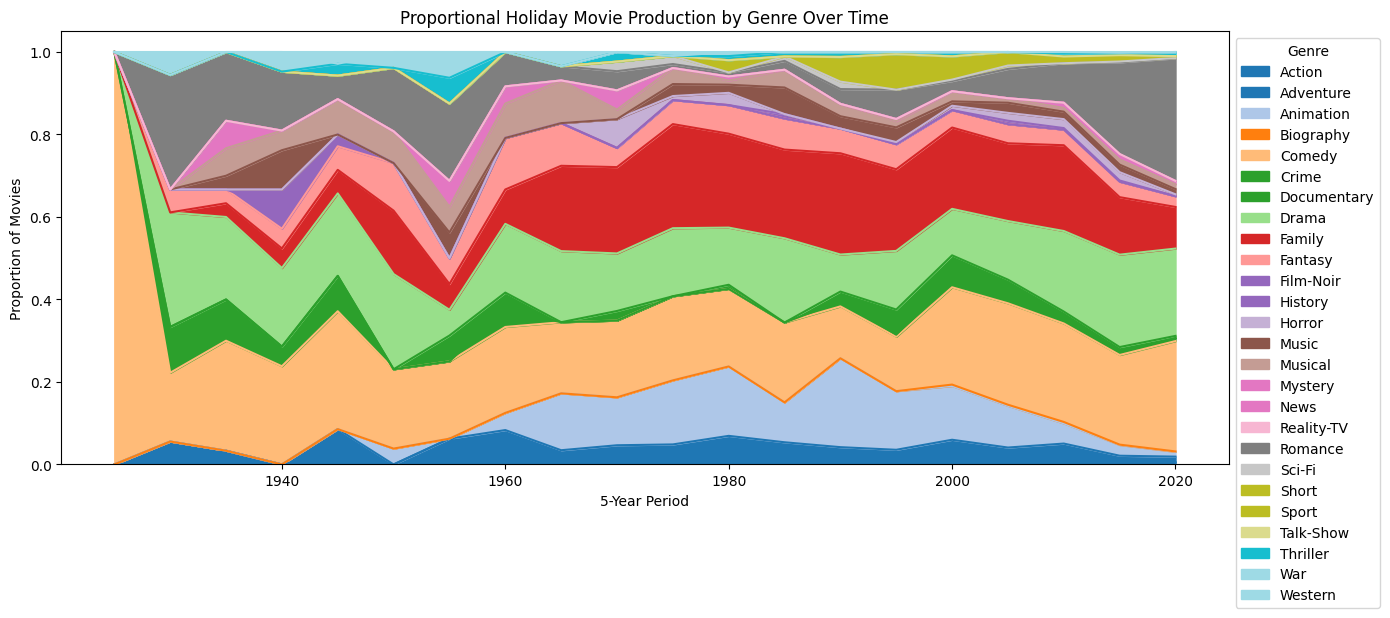

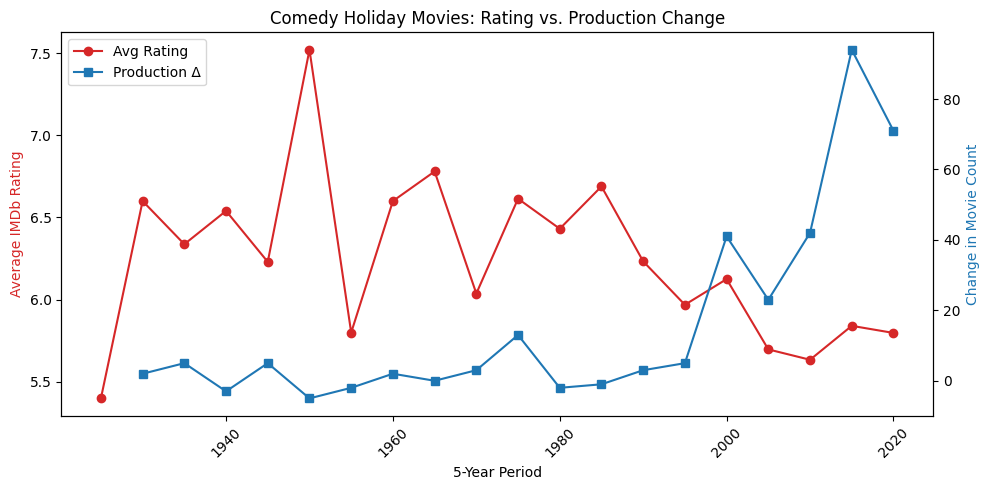

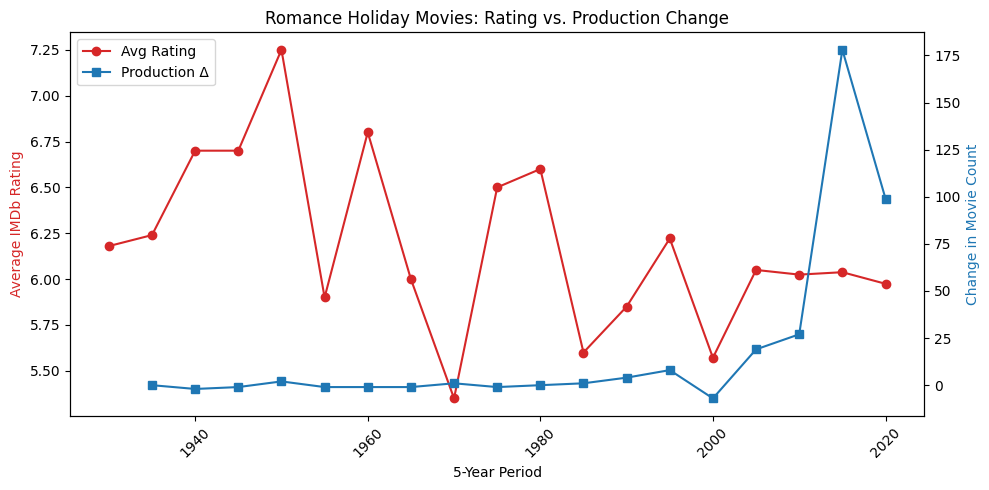

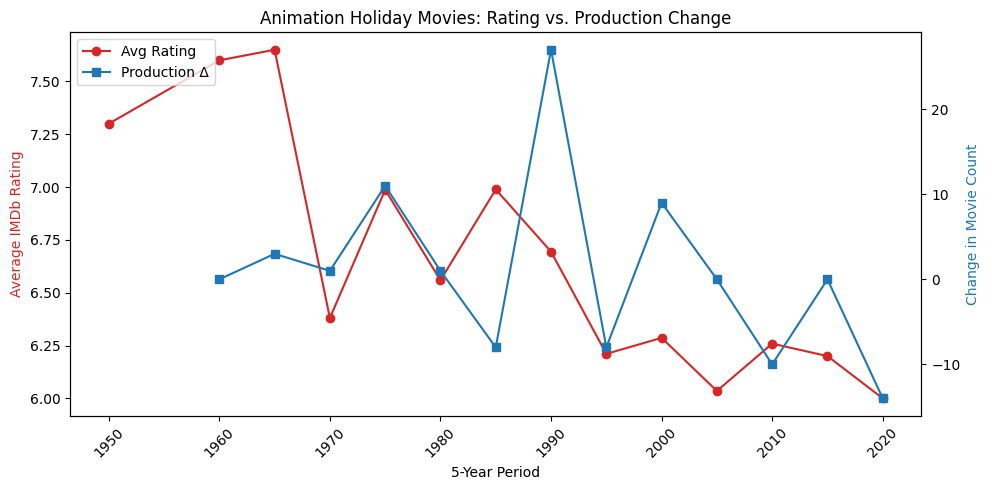

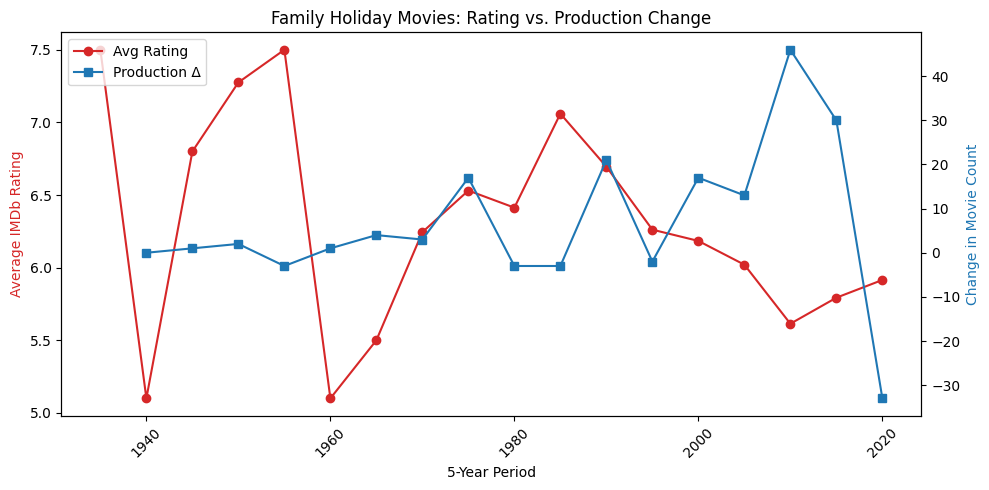

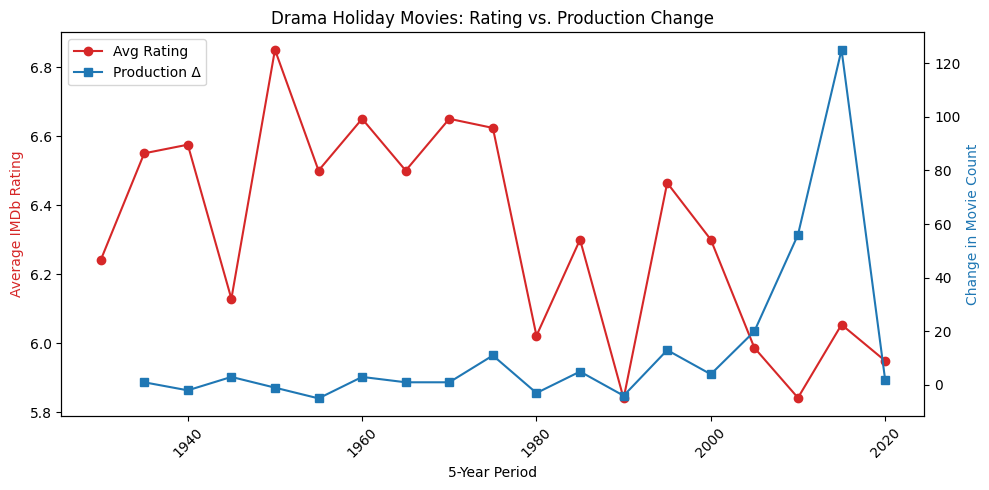

In [13]:
# Load the dataset
df = pd.read_csv("holiday_movies.csv")

# Clean missing data and explode genres
df = df.dropna(subset=['average_rating', 'runtime_minutes', 'genres'])
df['year_period'] = (df['year'] // 5) * 5
df['genres'] = df['genres'].str.split(',')
df_exploded = df.explode('genres')

# Aggregate total movie count by period and genre
genre_counts = df_exploded.groupby(['year_period', 'genres']).agg(
    count=('tconst', 'count')
).reset_index()

# Pivot to wide format for stacked area chart
pivot_counts = genre_counts.pivot(index='year_period', columns='genres', values='count').fillna(0)

# Normalize each row to get proportions (100% stacked)
pivot_props = pivot_counts.div(pivot_counts.sum(axis=1), axis=0)

# Plot the 100% stacked area chart
pivot_props.plot(kind='area', stacked=True, figsize=(14, 6), colormap='tab20')
plt.title("Proportional Holiday Movie Production by Genre Over Time")
plt.xlabel("5-Year Period")
plt.ylabel("Proportion of Movies")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Genre')
plt.tight_layout()
plt.show()

# Focus on 5 key genres
focus_genres = ['Comedy', 'Romance', 'Animation', 'Family', 'Drama']

# Aggregate stats by 5-year period and genre
agg = df_exploded[df_exploded['genres'].isin(focus_genres)].groupby(
    ['year_period', 'genres']
).agg(
    avg_rating=('average_rating', 'mean'),
    movie_count=('tconst', 'count')
).reset_index()

# Sort and calculate rate of change in movie count
agg = agg.sort_values(['genres', 'year_period'])
agg['production_change'] = agg.groupby('genres')['movie_count'].diff()

# Plot all 5 genres in one go
for genre in focus_genres:
    data = agg[agg['genres'] == genre]

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    ax1.plot(data['year_period'], data['avg_rating'], color='tab:red', marker='o', label='Avg Rating')
    ax2.plot(data['year_period'], data['production_change'], color='tab:blue', marker='s', label='Production Δ')

    ax1.set_xlabel('5-Year Period')
    ax1.set_ylabel('Average IMDb Rating', color='tab:red')
    ax2.set_ylabel('Change in Movie Count', color='tab:blue')
    plt.title(f'{genre} Holiday Movies: Rating vs. Production Change')
    ax1.tick_params(axis='x', rotation=45)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()
